In [1]:
import pandas as pd
import datetime as dt
import pandas_datareader as pdr
import numpy as np
import praw
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from praw.models import MoreComments
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [2]:
stock_symbol = 'TSLA'
stock_search = 'TSLA'
stock_date = '2020-01-01'

df = pd.read_csv('TSLA.csv', date_parser = True)
df = df.set_index('Date', drop = True)
df.index = pd.to_datetime(df.index)
data_training = df.loc[(df.index <= stock_date)]
data_test = df.loc[(df.index >= stock_date)]

data_test = data_test.reset_index()
data_training = data_training.reset_index()


print(data_training.shape)
print(data_training)
print(data_test)

data_training = data_training.drop(['Date', 'Polarity'], axis = 1)
data_training_test = data_training
data_test = data_test.drop(['Date', 'Polarity'], axis = 1)



(503, 7)
          Date       High        Low       Open      Close    Volume  Polarity
0   2018-01-02  64.421997  62.200001  62.400002  64.106003  21761000       0.0
1   2018-01-03  65.050003  63.110001  64.199997  63.450001  22607500       0.0
2   2018-01-04  63.709999  61.136002  62.574001  62.924000  49731500       0.0
3   2018-01-05  63.448002  62.400002  63.324001  63.316002  22956000       0.0
4   2018-01-08  67.403999  63.099998  63.200001  67.281998  49297000       0.0
..         ...        ...        ...        ...        ...       ...       ...
498 2019-12-24  85.094002  82.538002  83.671997  85.050003  40273500       0.0
499 2019-12-26  86.695999  85.269997  85.582001  86.188004  53169500       0.0
500 2019-12-27  87.061996  85.222000  87.000000  86.075996  49728500       0.0
501 2019-12-30  85.800003  81.851997  85.758003  82.940002  62932000       0.0
502 2019-12-31  84.258003  80.416000  81.000000  83.666000  51428500       0.0

[503 rows x 7 columns]
          Date     

In [3]:
# The values in the training data are not in the same range
# For getting all the values in between the range 0 to 1 use MinMaxScalar() 
# to improves the accuracy of prediction
scaler = MinMaxScaler()
data_training_normalized = scaler.fit_transform(data_training)
print(data_training)

# This sections of the code divides the data into chunks of 10 rows corresponds to 
# the length of data_traning. After dividing we are converting X_train and y_train
# into numpy arrays
X_train = []
y_train = []

for i in range(10, data_training_normalized.shape[0]):
    X_train.append(data_training_normalized[i-10:i])
    y_train.append(data_training_normalized[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)


          High        Low       Open      Close    Volume
0    64.421997  62.200001  62.400002  64.106003  21761000
1    65.050003  63.110001  64.199997  63.450001  22607500
2    63.709999  61.136002  62.574001  62.924000  49731500
3    63.448002  62.400002  63.324001  63.316002  22956000
4    67.403999  63.099998  63.200001  67.281998  49297000
..         ...        ...        ...        ...       ...
498  85.094002  82.538002  83.671997  85.050003  40273500
499  86.695999  85.269997  85.582001  86.188004  53169500
500  87.061996  85.222000  87.000000  86.075996  49728500
501  85.800003  81.851997  85.758003  82.940002  62932000
502  84.258003  80.416000  81.000000  83.666000  51428500

[503 rows x 5 columns]
(493, 10, 5)


In [4]:
# Build model
model = Sequential()

X_train.shape[1]

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 60)            15840     
_________________________________________________________________
dropout (Dropout)            (None, 10, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               96480     
__________

In [5]:
# past_10_days contains the data of the past 10 days required to predict the opening of the 1st day in the test data set.
past_10_days = data_training_test.tail(10)
print(past_10_days)

# We are going to append data_test to past_10_days and ignore the index of data_test
df = past_10_days.append(data_test, ignore_index = True)
print(df)

# Similar to the training data set we have to scale the test data so that all the values are in the range 0 to 1.
inputs = scaler.fit_transform(df)
inputs

# Prepare the test data like the training data.
X_test = []
y_test = []

for i in range(10, inputs.shape[0]):
    X_test.append(inputs[i-10:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

y_pred = model.predict(X_test)

print(scaler.scale_)

# Calcualte the original price back again
scale = 1/scaler.scale_[0]
print(scale)

# Prediction on the normal price scale
y_pred = y_pred*scale
y_test = y_test*scale

          High        Low       Open      Close    Volume
493  77.099998  75.180000  75.797997  75.797997  42484000
494  79.043999  76.115997  76.125999  78.629997  70605000
495  81.370003  79.300003  79.463997  80.807999  90535500
496  82.599998  80.038002  82.057999  81.117996  73763500
497  84.402000  82.000000  82.356003  83.844002  66598000
498  85.094002  82.538002  83.671997  85.050003  40273500
499  86.695999  85.269997  85.582001  86.188004  53169500
500  87.061996  85.222000  87.000000  86.075996  49728500
501  85.800003  81.851997  85.758003  82.940002  62932000
502  84.258003  80.416000  81.000000  83.666000  51428500
           High         Low        Open       Close    Volume
0     77.099998   75.180000   75.797997   75.797997  42484000
1     79.043999   76.115997   76.125999   78.629997  70605000
2     81.370003   79.300003   79.463997   80.807999  90535500
3     82.599998   80.038002   82.057999   81.117996  73763500
4     84.402000   82.000000   82.356003   83.844002 

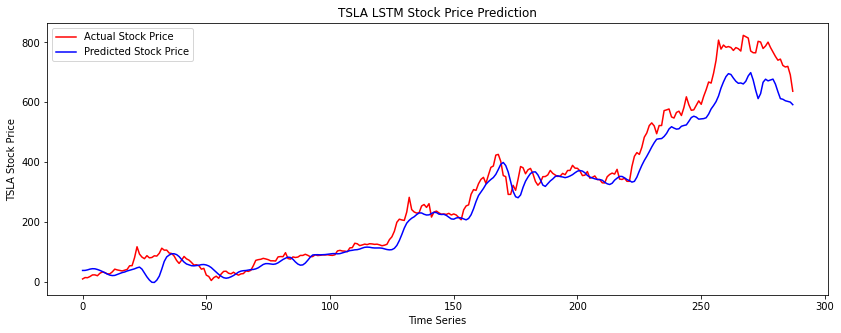

In [6]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title(stock_symbol + ' LSTM Stock Price Prediction')
plt.xlabel('Time Series')
plt.ylabel(stock_symbol + ' Stock Price')
plt.legend()
plt.show()


In [7]:
MSE_error = mean_squared_error(y_test, y_pred)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 2821.0585184734773


In [8]:
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]

training_data = train_data['Close'].values
test_data = test_data['Close'].values

history = [x for x in training_data]

model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))


Testing Mean Squared Error is 608.482737852209


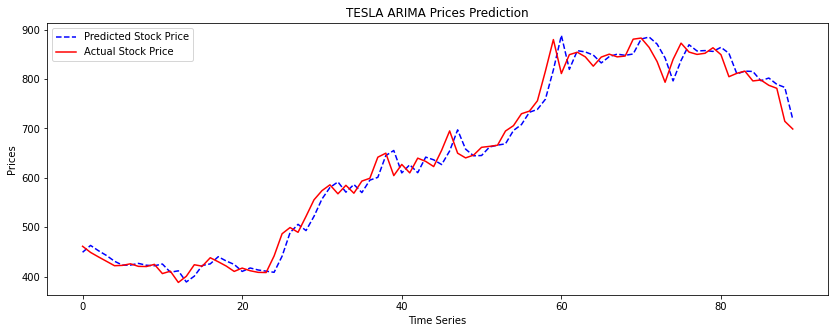

In [9]:
# Visualising the results
test_set_range = df[int(len(df)*0.7):].index

plt.figure(figsize=(14,5))
plt.plot(model_predictions, color='blue', linestyle='dashed',label='Predicted Stock Price')
plt.plot(test_data, color='red', label='Actual Stock Price')
plt.title('TESLA ARIMA Prices Prediction')
plt.xlabel('Time Series')
plt.ylabel('Prices')
plt.legend()
plt.show()

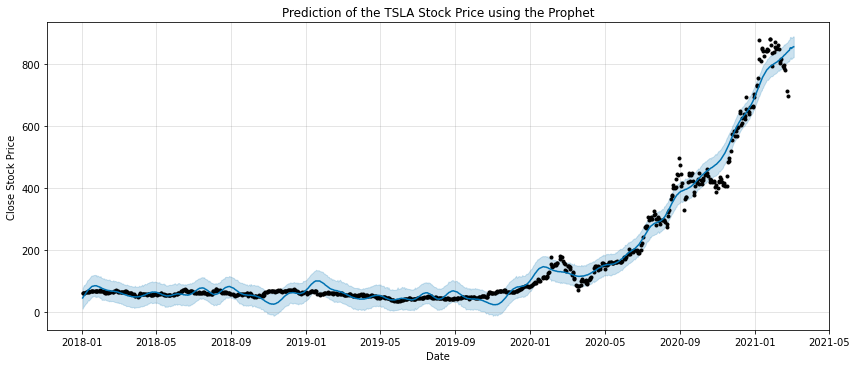

            ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2018-01-02   57.514647   12.062026   78.092839    57.514647    57.514647   
1   2018-01-03   57.702940   17.379693   82.749595    57.702940    57.702940   
2   2018-01-04   57.891233   19.523457   88.498931    57.891233    57.891233   
3   2018-01-05   58.079525   23.197883   87.128846    58.079525    58.079525   
4   2018-01-08   58.644403   30.720766   95.899306    58.644403    58.644403   
..         ...         ...         ...         ...          ...          ...   
796 2021-03-01  854.847217  817.317152  884.933500   854.847217   854.847217   
797 2021-03-02  857.303432  819.487491  885.671029   857.303432   857.303432   
798 2021-03-03  859.759648  820.936499  888.286460   859.759648   859.759648   
799 2021-03-04  862.215863  822.951628  890.586246   862.215863   862.215863   
800 2021-03-05  864.672078  823.427652  890.317089   864.672078   864.672078   

     additive_terms  additive_terms_low

In [49]:
from fbprophet import Prophet

df = pd.read_csv('TSLA.csv', date_parser = True)
df = df.set_index('Date', drop = True)
df.index = pd.to_datetime(df.index)
training_data = df.loc[(df.index) >= '2021-01-01']
training_data.rename(columns={'Close': 'y'},inplace=True)
training_data['ds'] = pd.to_datetime(training_data.index)
training_data['y'] = training_data['y'].astype(float)

m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(training_data) # fit the model using training data

future = m.make_future_dataframe(periods=10) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction, figsize=(12, 5))
plt.title("Prediction of the TSLA Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

print(prediction)

print(prediction[['ds', 'trend']])


In [43]:
for i in range(len(X_test)):
    if (y_pred[i] - y_pred[i-1] > 0):
        print("{0} Buy".format(y_pred[i]))
    else:
        print("{0} Sell".format(y_pred[i]))


[76.26936] Sell
[77.63126] Buy
[78.44531] Buy
[78.9839] Buy
[78.33291] Sell
[75.8191] Sell
[71.20843] Sell
[66.89404] Sell
[62.82085] Sell
[59.222763] Sell
[56.38393] Sell
[54.28448] Sell
[54.684612] Buy
[55.573883] Buy
[57.468727] Buy
[60.394516] Buy
[62.704063] Buy
[64.11216] Buy
[68.0316] Buy
[72.04471] Buy
[73.983406] Buy
[76.33519] Buy
[76.18053] Sell
[72.65308] Sell
[66.07551] Sell
[55.434296] Sell
[44.78495] Sell
[36.97706] Sell
[34.541477] Sell
[40.11157] Buy
[51.954334] Buy
[64.04278] Buy
[81.25059] Buy
[95.53437] Buy
[103.66589] Buy
[108.70987] Buy
[110.98508] Buy
[111.48642] Buy
[108.719215] Sell
[103.04444] Sell
[97.64075] Sell
[91.02513] Sell
[86.41947] Sell
[85.37511] Sell
[85.3201] Sell
[87.19468] Buy
[89.307205] Buy
[90.42945] Buy
[90.29162] Sell
[88.57345] Sell
[85.90155] Sell
[81.284096] Sell
[76.60163] Sell
[69.80148] Sell
[62.213375] Sell
[54.656418] Sell
[49.50759] Sell
[46.42413] Sell
[45.45341] Sell
[47.66209] Buy
[51.69953] Buy
[56.924072] Buy
[62.47529] Buy
[67